# Polynomial Model

This section provides implementation for concepts related to polynomial model. First, a simple linear model (polynomial model with order=1) is discussed. Then, polynomial models with different orders are also demonstrated. The concept of simple and k-fold cross validation is also described using the polynomial model.

> __NOTE__: You need to install `scikit learn` package using `pip install scikit-learn`. This package provides various tools for building machine learning models in Python. Also, install the latest version of `scimlstudio` package as described in setup section.

A general $n^{th}$ order polynomial model is written as $y = \pmb{\psi} \cdot \mathbf{w}^T$, where $\pmb{\psi}$ and $\mathbf{w}$ are the basis and weight vectors, respectively. The $\pmb{\psi}$ and $\mathbf{w}$ are given as

$$
    \pmb{\psi} = [1 \quad x \quad \dots \quad x^{n-1} \quad x^n]^T \quad \text{and} \quad \mathbf{w} = [w_1 \quad w_2 \quad \dots \quad w_{n-1} \quad w_{n}]^T
$$

The goal is to find the weight vector for a given data, which can then be used for inference. Refer to lecture notes for more details.

Below block of code imports required packages:

In [ ]:
import numpy as np
from pyDOE3 import lhs
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, train_test_split
from scipy.stats import norm
import matplotlib.pyplot as plt

## Linear Model

The first step is to import the `Polynomial` model class from the `scimlstudio` package. Then, this class is initialized using the training data and the order of the polynomial. Next, the `fit` method is called to determine the weight vector of the polynomial. This sub-section illustrates these steps using a simple linear model. Note that for a linear model, basis vector will be $\pmb{\psi} = [1 \quad x]^T$.

Below block of code defines the training dataset and plots it:

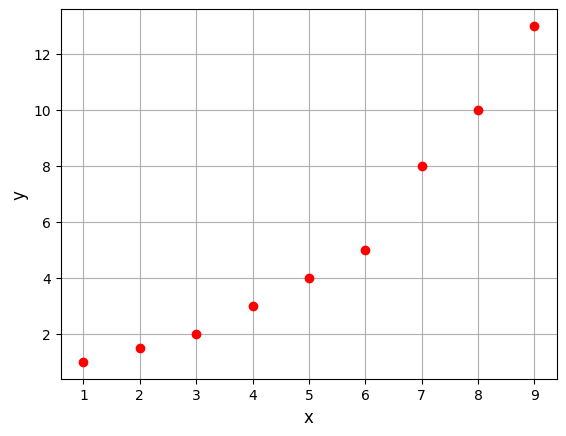

In [21]:
# Training data
xtrain = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
ytrain = np.array([1, 1.5, 2, 3, 4, 5, 8, 10, 13])

# Plotting the training data
fs = 12
fig, ax = plt.subplots()
ax.plot(xtrain, ytrain, 'ro', label='Training data')
ax.set_xlabel('x', fontsize=fs)
ax.set_ylabel('y', fontsize=fs)
ax.grid()

Below block of code uses the function defined above to fit a line to the training data:

In [22]:
import torch
from scimlstudio.models import Polynomial # import polynomial model

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float64
args = {"device": device, "dtype":dtype}

# initialize the polynomial model
model = Polynomial(
    xtrain=torch.from_numpy(xtrain).to(device=device, dtype=dtype).reshape(-1,1), 
    ytrain=torch.from_numpy(ytrain).to(device=device, dtype=dtype).reshape(-1,1), 
    order=1
)

w = model.fit()

print(w)

tensor([[-2.0139],
        [ 1.4583]], device='cuda:0', dtype=torch.float64)


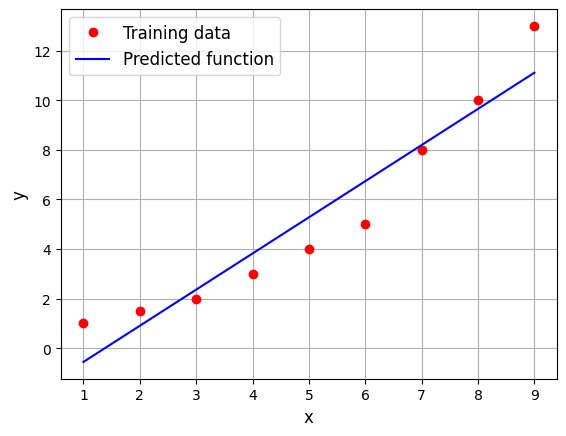

In [24]:
# Testing x
xtest = np.linspace(1, 9, 100)

# Predicting the output
ypred = model.predict(torch.from_numpy(xtest).to(device=device, dtype=dtype).reshape(-1,1)).numpy(force=True)

fs = 12
fig, ax = plt.subplots()
ax.plot(xtrain, ytrain, 'ro', label='Training data')
ax.plot(xtest, ypred, 'b-', label='Predicted function')
ax.set_xlabel('x', fontsize=fs)
ax.set_ylabel('y', fontsize=fs)
ax.grid()
ax.legend(fontsize=fs)

## Fitting $2^{nd}$ order polynomial

We will be using following function to generate data:

$$
f(x) = (6x - 2)^2sin(12x-4) + \epsilon
$$

where

$$
\epsilon \sim \mathcal{N}(0,1) \text{ and } 0 \leq x \leq 1
$$

This will generate a noisy data around function $(6x - 2)^2sin(12x-4)$. Below block of code generates 20 noisy samples and plots it.

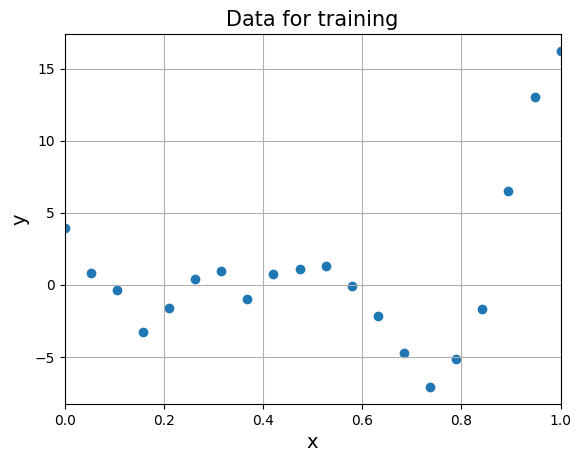

In [27]:
# Few variables
num_samples = 20
xlower = 0
xupper = 1
random_state = 20

# Training data
x = np.linspace(xlower, xupper, num_samples)
y = (6*x - 2)**2 * np.sin(12*x - 4) + norm.rvs(size=x.shape, random_state=random_state)

# Plotting
plt.scatter(x, y)
plt.xlim((xlower, xupper))
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.title("Data for training", fontsize=15)
plt.grid()

A one variable 2nd order polynomial will be fit to above data. Later, techniques like cross-validation will be used to find order of the polynomial. Basis function vector will be:

$$
\pmb{\psi} = [1\quad x \quad x^2]^T
$$

Below block of code defines two functions - `fit_polynomial` and `predict`. First function is used to get a least square estimate for fitting a $m^{th}$ order polynomial to the given data. Second function is used for getting the prediction at given input `x` based on the parameter values. Please read comments in the code for more details.

Below block of code fits a 2nd order polynomial to the noisy data and plots the prediction based on parameter values.

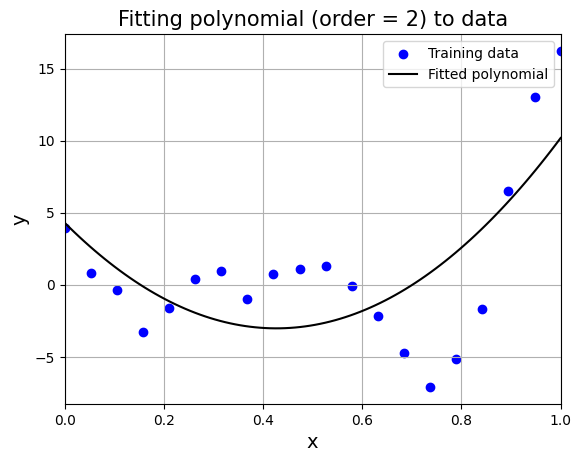

In [29]:
order = 2 # order of the polynomial

# initialize the polynomial model
model = Polynomial(
    xtrain=torch.from_numpy(x).to(device=device, dtype=dtype).reshape(-1,1), 
    ytrain=torch.from_numpy(y).to(device=device, dtype=dtype).reshape(-1,1), 
    order=2
)

w = model.fit() # fit the model

xtest = np.linspace(xlower, xupper, 100) # Test input values

ypred = model.predict(torch.from_numpy(xtest).to(device=device, dtype=dtype).reshape(-1,1)).numpy(force=True) # Prediction

# Plotting the predicted values and data
plt.scatter(x, y, c="b", label="Training data")
plt.plot(xtest, ypred, "k", label="Fitted polynomial")
plt.xlim((xlower, xupper))
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.legend()
plt.title("Fitting polynomial (order = {}) to data".format(order), fontsize=15)
plt.grid()

We can see that model is not able to capture the underlying trend in the data. We will use cross-validation to find the order of the polynomial.

## Fitting $m^{th}$ order polynomial

As explained in the lecture, cross validation is used to find the order of polynomial and avoids over-fitting the data. First, we will look into simple cross-validation and later into k-fold cross-validation. For performing simple cross-validation, data needs to be split into two parts - training and testing. To do this, `train_test_split` method from `scikit-learn` will be used. Read the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn-model-selection-train-test-split) for more details. 

Below block of code splits the data into two parts, performs simple cross validation by fitting polynomial of various orders and calculates normalized RMSE. Finally, it plots the variation of NRMSE with respect to order of polynomial. Read comments in the code for more details.

Text(0.5, 1.0, 'Variation of NRMSE with order')

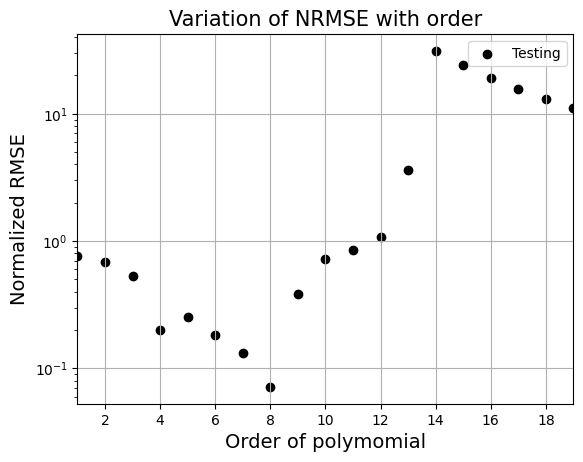

In [42]:
from scimlstudio.utils import evaluate_scalar

# Creating 1d numpy array which contains orders
orders = np.arange(1, 20, dtype=int)

# Spliting the data into two parts
# Data is split into 75% training and 25% testing
# Note: random_state fixes the seed, so the results are same everytime
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.25, random_state=random_state)

# Initializing normalized RMSE list
test_metric = []

for order in orders:

    # Fit a particular order of polynomial
    model = Polynomial(
        xtrain = torch.from_numpy(xtrain).to(device=device, dtype=dtype).reshape(-1,1),
        ytrain = torch.from_numpy(ytrain).to(device=device, dtype=dtype).reshape(-1,1),
        order = int(order)
    )

    model.fit()
    
    # Get the prediction at training nad testing points
    ytest_pred = model.predict(torch.from_numpy(xtest).to(device=device, dtype=dtype).reshape(-1,1))

    # Calculate normalized rmse for training and testing prediction
    nrmse = evaluate_scalar(torch.from_numpy(ytest).to(device=device, dtype=dtype), ytest_pred.reshape(-1,), metric="nrmse")

    test_metric.append(nrmse)

# Plotting the NRMSE
plt.scatter(orders, np.array(test_metric), c="k", label="Testing")
plt.xlim((orders[0], orders[-1]))
plt.xlabel("Order of polymomial", fontsize=14)
plt.ylabel("Normalized RMSE", fontsize=14)
plt.yscale("log")
plt.legend()
plt.grid()
plt.title("Variation of NRMSE with order".format(order), fontsize=15)

From the above graph, order = 6 gives the least nrmse. Below block of code fits polynomial of order 6 to data and plots it. Feel free to change the order and see what happens to the fit.

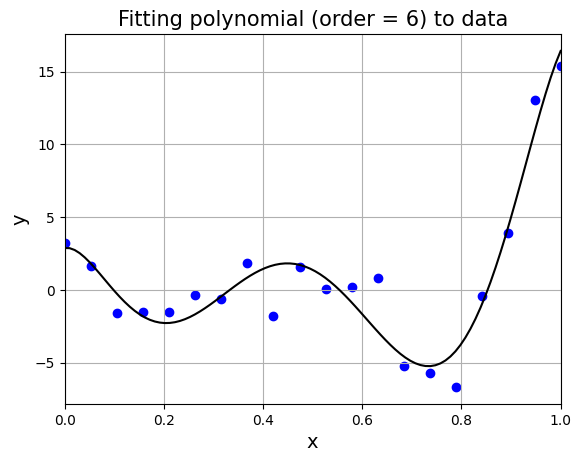

In [ ]:
order = 6 # order of the polynomial

w = fit_polynomial(x, y, order, print_weight=False) # Get the wieghts

x_test = np.linspace(xlower, xupper, 100) # Test input values

y_pred = predict(x_test, w) # Prediction

# Plotting the predicted values and data
plt.scatter(x, y, c="b")
plt.plot(x_test, y_pred, "k")
plt.xlim((xlower, xupper))
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.title("Fitting polynomial (order = {}) to data".format(order), fontsize=15)
plt.grid()

To implement **K-fold cross validation**, dataset needs to be split into k smaller sets. `KFold` method within `scikit-learn` will be used to split the dataset. Read [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn-model-selection-kfold) for more information. Below block of code performs 5-fold cross validation to find the order of polynomial. Read comments in the code for more details.

Text(0.5, 1.0, 'Variation of NRMSE with order')

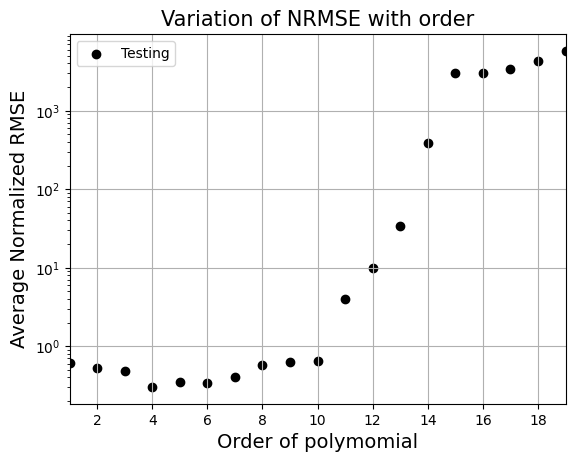

In [ ]:
# Creating 1d numpy array which contains orders
orders = np.arange(1, 20,  dtype=int)

# number of folds
n_splits = 5

# Initializing normalized RMSE list
test_metric = []

# Initializing the K Fold object
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Fitting various polynomials
for order in orders:
    
    # Setting starting value of nrmse
    nrmse = 0
    
    # Fitting the polynomial of a particular order to each fold
    # and computing nrmse of the fit
    for (train_index, test_index) in kf.split(x):
        
        # Getting training data
        x_train = x[train_index]
        y_train = y[train_index]
        
        # Getting testing data
        x_test = x[test_index]
        y_test = y[test_index]

        # Fit a particular order of polynomial
        w = fit_polynomial(x_train, y_train, order, print_weight=False)

        # Get the prediction at training nad testing points
        y_test_pred = predict(x_test, w)
        
        # Adding all the nrmse to calculate average later
        nrmse = nrmse + np.sqrt(mean_squared_error(y_test, y_test_pred)) / np.ptp(y_test)
        
    # Calculating average nrmse
    test_metric.append(nrmse/n_splits)
        
# Plotting the NRMSE
plt.scatter(orders, np.array(test_metric), c="k", label="Testing")
plt.xlim((orders[0], orders[-1]))
plt.xlabel("Order of polymomial", fontsize=14)
plt.ylabel("Average Normalized RMSE", fontsize=14)
plt.yscale("log")
plt.legend()
plt.grid()
plt.title("Variation of NRMSE with order".format(order), fontsize=15)

From the above graph, order = 4 gives least nrmse. Below block of code fits polynomial of order 4 to data and plots it. Feel free to change the order and see what happens to the fit.

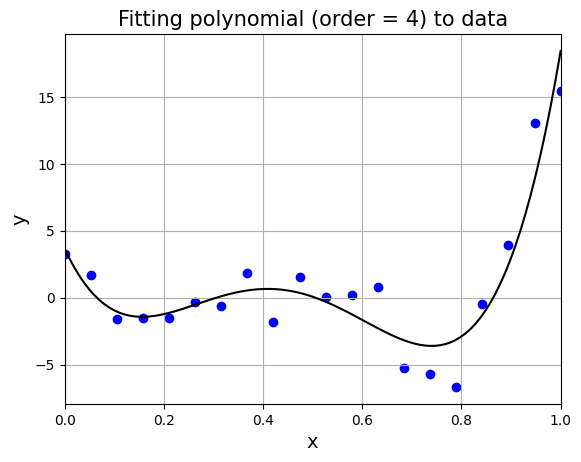

In [ ]:
order = 4 # order of the polynomial

w = fit_polynomial(x, y, order, print_weight=False) # Get the weight

x_test = np.linspace(xlower, xupper, 100) # Test input values

y_pred = predict(x_test, w) # Prediction

# Plotting the predicted values and data
plt.scatter(x, y, c="b")
plt.plot(x_test, y_pred, "k")
plt.xlim((xlower, xupper))
plt.xlabel("x", fontsize=14)
plt.ylabel("y", fontsize=14)
plt.title("Fitting polynomial (order = {}) to data".format(order), fontsize=15)
plt.grid()

This concludes polynomial model section.